# Кластеризация

Датасет: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data

План действий:
* только числовые признаки - 4 характеристики;
* методы кластеризации, где можно задать количество кластеров;
* похожесть на разбиение по видам и просто хорошее разбиение (силуэт и v-мера);
* сделать общие датафреймы с метриками (по одному на каждую метрику), с помощью melt выявить наилучшую комбинацию признаки + скейлер + метод кластеризации;
* pd.crosstab, confusion matrix;
* комбинации 2-3-4 признака;
* разные скейлеры;
* двумерная визуализация с помощью PCA;
* сводная статистика по скейлерам, по комбинациям и по видам для каждой метрики.

Импорт библиотек

In [42]:
import numpy as np
import pandas as pd
import itertools

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# предобработка
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
# from sklearn.impute import SimpleImputer

# кластеризация
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# метрики
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

# методы уменьшения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# пайплайны
from sklearn.pipeline import Pipeline

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

Цвета и константы

In [43]:
SPECIES_COLORS_A_C_G = ['darkorange', 'mediumorchid', 'darkcyan']
# SPECIES_COLORS_A_G_C = ['darkorange', 'darkcyan', 'mediumorchid']
NOT_SPECIES_COLORS = ['cyan', 'deeppink', 'lime', 'coral', 'yellow', 'darkorchid', 'red', 'cornflowerblue', 'springgreen', 'gold', 'fuchsia']
CLUSTER_COLORS = ['cyan', 'deeppink', 'lime']
SPECIES_PALETTE_A_C_G = sns.color_palette(SPECIES_COLORS_A_C_G)
NOT_SPECIES_PALETTE = sns.color_palette(NOT_SPECIES_COLORS)
CLUSTER_PALETTE = sns.color_palette(CLUSTER_COLORS)

SEED = 42
FIGSIZE = (5, 7)
MULTIPLOT_FIGZSIZE = (FIGSIZE[0] * 3 + 2, FIGSIZE[1])

picture_prefix = "Clust_"
picture_extension = ".jpg"

Словари с метриками

In [44]:
silhouette_score_dict = {"AgglomerativeClustering": [], "KMeans": []}
v_measure_score_dict = {"AgglomerativeClustering": [], "KMeans": []}
feature_combinations_lst = []

Словари с метками

In [45]:
labels_dict = {"AgglomerativeClustering":{}, "KMeans":{}}

In [46]:
penguins_data = pd.read_csv('penguins_lter.csv')
penguins_data.sample(n=5, random_state=42)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
194,PAL0809,43,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N75A1,Yes,11/14/08,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594,NaN
157,PAL0708,6,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N64A2,Yes,11/21/07,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433,NaN
225,PAL0708,6,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N33A2,Yes,11/18/07,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829,NaN
208,PAL0910,57,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N94A1,Yes,11/21/09,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984,NaN
318,PAL0910,99,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N21A1,Yes,11/18/09,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971,NaN


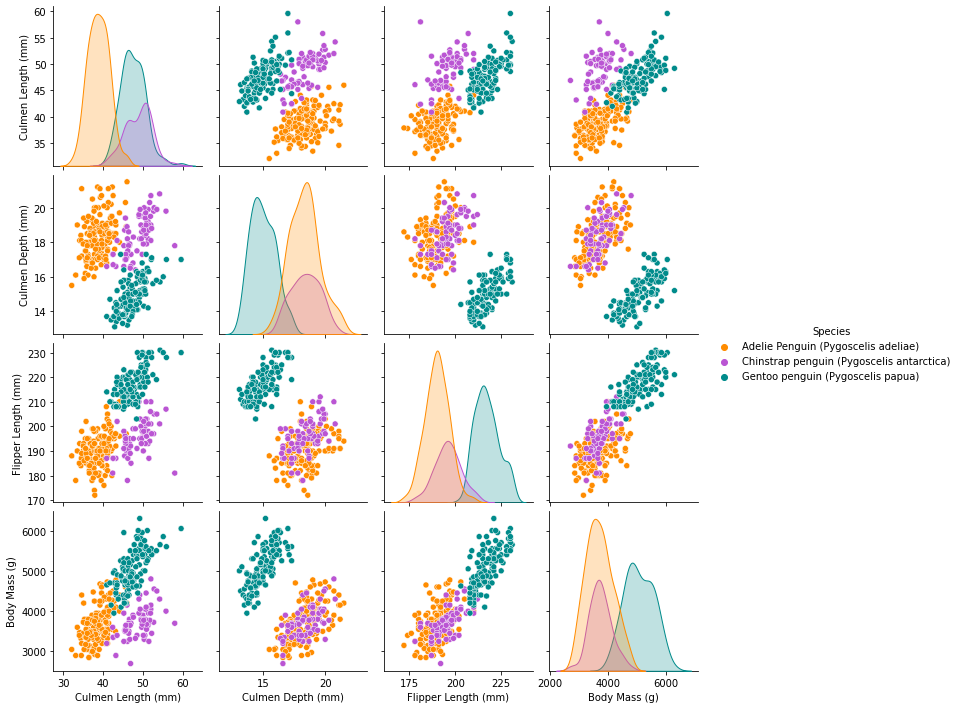

In [47]:
sns.pairplot(penguins_data[['Culmen Length (mm)','Culmen Depth (mm)',
                            'Flipper Length (mm)', 'Body Mass (g)', 'Species']], 
             hue='Species', palette=SPECIES_PALETTE_A_C_G);

### Немного предобработки

Пока только числовые

*если останется время, можно будет добавить с кровью*

In [48]:
penguins_data_numerical_and_species = penguins_data[['Culmen Length (mm)','Culmen Depth (mm)',
                            'Flipper Length (mm)', 'Body Mass (g)', 'Species']]

Посмотреть и выкинуть пустые

*если останется время, можно будет заполнить*

In [49]:
penguins_data_numerical_and_species.isna().sum()

Culmen Length (mm)     2
Culmen Depth (mm)      2
Flipper Length (mm)    2
Body Mass (g)          2
Species                0
dtype: int64

In [50]:
penguins_data_numerical_and_species = penguins_data_numerical_and_species.dropna()

In [51]:
penguins_data_numerical_and_species.isna().sum()

Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Body Mass (g)          0
Species                0
dtype: int64

Перевод меток видов в численные

In [52]:
enc = OrdinalEncoder()
species_labels = enc.fit_transform(penguins_data_numerical_and_species[['Species']])[:, 0]

## Кластеризация

### Кластеризация

In [53]:
scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler}

Получение меток

In [54]:
def get_labels(df, feature_combination_name, whether_to_scale=False, scaler_name=StandardScaler):
  hierarchial_labels = []
  kmeans_labels = []
  if not whether_to_scale:
    hierarchial_labels = AgglomerativeClustering(n_clusters=3).fit_predict(df)
    kmeans_labels = KMeans(n_clusters=3, n_init=100, random_state=SEED).fit_predict(df)
  else:
    pipe = Pipeline([('scaler', scaler_dict[scaler_name]()), ('clust', AgglomerativeClustering(n_clusters=3))])
    hierarchial_labels = pipe.fit_predict(df)
    pipe = Pipeline([('scaler', scaler_dict[scaler_name]()), ('clust', KMeans(n_clusters=3, n_init=100, random_state=SEED))])
    kmeans_labels = pipe.fit_predict(df)

  labels_dict["AgglomerativeClustering"][feature_combination_name] = hierarchial_labels.copy()
  labels_dict["KMeans"][feature_combination_name] = kmeans_labels.copy()

Подсчет метрик

In [55]:
def count_metrics(df, columns_lst, feature_combination_name):
  silhouette_score_AC = silhouette_score(df[columns_lst], 
                                         labels_dict["AgglomerativeClustering"][feature_combination_name])
  silhouette_score_KM = silhouette_score(df[columns_lst], 
                                         labels_dict["KMeans"][feature_combination_name])

  v_measure_score_AC = v_measure_score(labels_dict["AgglomerativeClustering"][feature_combination_name], species_labels)
  v_measure_score_KM = v_measure_score(labels_dict["KMeans"][feature_combination_name], species_labels)

  silhouette_score_dict["AgglomerativeClustering"].append(silhouette_score_AC)
  silhouette_score_dict["KMeans"].append(silhouette_score_KM)

  v_measure_score_dict["AgglomerativeClustering"].append(v_measure_score_AC)
  v_measure_score_dict["KMeans"].append(v_measure_score_KM)

  feature_combinations_lst.append(feature_combination_name)

Запуск функций для отдельной комбинации скейлер+признаки

In [56]:
def work_with_columns(df, columns_lst_, whether_to_scale, scaler_name):
  feature_comb = " ".join([scaler_name, *columns_lst_])
  df_cur = df[columns_lst_]
  get_labels(df_cur, feature_comb, whether_to_scale, scaler_name)
  count_metrics(df_cur, columns_lst=columns_lst_, feature_combination_name=feature_comb)

Перебор всевозможных комбинаций скейлер+признаки

In [57]:
def count_scores_for_all_combinations(df, feature_name_lst_=['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
       'Body Mass (g)'], scaler_name_lst=['initial', 'StandardScaler', 'MinMaxScaler']):
  combinations_lst = list(itertools.chain.from_iterable([list(itertools.combinations(feature_name_lst_, r))\
                                                         for r in range(2, len(feature_name_lst_) + 1)]))
  comb_with_scaler_lst = list(itertools.product(scaler_name_lst, combinations_lst))

  for comb in comb_with_scaler_lst:
    work_with_columns(df, columns_lst_=[x for x in comb[1]], whether_to_scale=(comb[0] != "initial"), scaler_name=comb[0])

Запуск перебора

In [58]:
count_scores_for_all_combinations(penguins_data_numerical_and_species)

## Работа с результатами

### Вспомогательные функции

Создание датасета метрик из словарей

In [59]:
def get_full_metric_df(metric_dict, metric_name, feature_combinations_lst_=feature_combinations_lst):
  metric_df = pd.DataFrame({"AgglomerativeClustering": metric_dict["AgglomerativeClustering"],
                            "KMeans": metric_dict["KMeans"],
                            "combination": feature_combinations_lst_})
  metric_df["scaler"] = metric_df.combination.apply(lambda x: x.split(' ')[0])
  metric_df["feature_combination"] = metric_df.combination.apply(lambda x: ' '.join(x.split(' ')[1::]))
  melted_metric_df = pd.melt(metric_df, ignore_index=True, id_vars=["combination", "feature_combination", "scaler"], \
                             value_vars=["AgglomerativeClustering", "KMeans"]) \
                             .rename(columns={"variable": "clustering_method", "value":metric_name}) \
                             .sort_values(by=metric_name, ascending=False) \
                             .reset_index(drop=True)
  return melted_metric_df

Отрисовка столбчатой диаграммы со значениями метрик

In [60]:
def paint_metric_values(melted_metric_df, metric_name):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(True)
  plt.xlim(right=1)
  sns.barplot(data=melted_metric_df, y="combination", x=metric_name, hue="clustering_method", 
              orient="h", palette=NOT_SPECIES_PALETTE);

  fig.savefig(''.join([picture_prefix, metric_name + "_hbar", picture_extension]), bbox_inches='tight')

Отрисовка боксплотов для метрик в группировках

In [61]:
def get_and_paint_statistics_for_grouping(melted_metric_df, metric_name, group_lst, to_paint=True, figsize_=(8, 6)):
  display(melted_metric_df.groupby(group_lst).agg(['count', 'min', 'max', np.mean, np.median]))

  if to_paint and len(group_lst) in [1, 2]:
    if group_lst[0] != 'feature_combination':
      fig = plt.figure(figsize=figsize_)
      plt.ylim(top=1)
      if len(group_lst) == 1:
        sns.boxplot(data=melted_metric_df, x=group_lst[0], y=metric_name, palette=NOT_SPECIES_PALETTE);
      else:
        sns.boxplot(data=melted_metric_df, x=group_lst[0], y=metric_name, hue=group_lst[1], palette=NOT_SPECIES_PALETTE);
    else:
      fig = plt.figure(figsize=(10, 10))
      plt.xlim(right=1)
      sns.boxplot(data=melted_metric_df, y=group_lst[0], x=metric_name, palette=NOT_SPECIES_PALETTE);

    fig.savefig(''.join([picture_prefix, "_".join(["group_for", metric_name, "by", *group_lst]), picture_extension]), bbox_inches='tight')

Получение топ i строки датасета - комбинация скейлер+признаки, метод, метки и значение метрики

In [62]:
def get_top_combination(melted_score_df_, metric_name_, ind=0):
  top_combination = " ".join(map(str, [melted_score_df_.scaler[ind], melted_score_df_.feature_combination[ind]]))
  # top_combination = melted_score_df_.combination[0]
  top_method = melted_score_df_.clustering_method[ind]
  top_labels = labels_dict[top_method][top_combination].copy()
  top_score = melted_score_df_[metric_name_][ind]

  return top_combination, top_method, top_labels, top_score

Отрисовка топ-5 (или сколько задать) confusion matrix

In [63]:
def get_and_paint_top_labels(melted_score_df_, metric_name, n_top=5, figsize_=(15, 8)):
  fig = plt.figure(figsize=figsize_)
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.45, wspace=0.2)

  for i in range(n_top):
    top_combination_, top_method_, top_labels_, top_score = get_top_combination(melted_score_df_, metric_name, ind=i)
    matrix = pd.DataFrame({'labels': top_labels_, 'species': penguins_data_numerical_and_species['Species'].apply(lambda x: x.split(' ')[0])})
    ct = pd.crosstab(matrix['labels'], matrix['species']).astype(int).T

    comb_lst = top_combination_.split(' ')
    scaler = comb_lst[0]
    feat_comb = comb_lst[1::]
    brief_comb = ' '.join([feat_comb[i][0:3:] for i in range(len(feat_comb)) if (i + 1) % 3 != 0])

    ax_ = fig.add_subplot(n_top // 3 + 1, 3, i + 1)
    # ax_.grid(True)
    sns.heatmap(ax=ax_, data=ct, annot=True, center=0, cmap='plasma', fmt="g");
    ax_.set_title(f'''Top {i + 1} by {metric_name}
{brief_comb}
{' '.join([scaler, top_method_])}
score={top_score:.5f}''');

  plt.savefig(''.join([picture_prefix, "_".join(["top", str(n_top), "conf_matr_by", metric_name]), picture_extension]), bbox_inches='tight')

Отрисовка топ-5 (или сколько задать) scatter с кластерами и scatter для меток видов

In [64]:
def get_and_paint_top_points(melted_score_df_, metric_name, n_top=5, figsize_=(15, 8)):
  pca_transformed_df = PCA(n_components=2) \
  .fit_transform(penguins_data_numerical_and_species[['Culmen Length (mm)', 
  'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']])

  fig = plt.figure(figsize=figsize_)
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.45, wspace=0.2)

  for i in range(n_top):
    top_combination_, top_method_, top_labels_, top_score = get_top_combination(melted_score_df_, metric_name, ind=i)
    
    comb_lst = top_combination_.split(' ')
    scaler = comb_lst[0]
    feat_comb = comb_lst[1::]
    brief_comb = ' '.join([feat_comb[i][0:3:] for i in range(len(feat_comb)) if (i + 1) % 3 != 0])

    ax_ = fig.add_subplot(n_top // 3 + 1, 3, i + 1)
    ax_.grid(True)
    sns.scatterplot(ax=ax_, x=pca_transformed_df[:, 0], y=pca_transformed_df[:, 1], 
                  hue=top_labels_, palette=CLUSTER_PALETTE)
    ax_.set_xlabel('PC1')
    ax_.set_ylabel('PC2')
    ax_.set_title(f'''Top {i + 1} by {metric_name}
{brief_comb}
{' '.join([scaler, top_method_])}
score={top_score:.5f}''');

  # species
  ax_ = fig.add_subplot(n_top // 3 + 1, 3, n_top + 1)
  ax_.grid(True)
  sns.scatterplot(ax=ax_, x=pca_transformed_df[:, 0], y=pca_transformed_df[:, 1], 
                  hue=penguins_data_numerical_and_species.Species, palette=SPECIES_PALETTE_A_C_G) 
  ax_.set_xlabel('PC1')
  ax_.set_ylabel('PC2')
  ax_.set_title(f'Species');

  plt.savefig(''.join([picture_prefix, "_".join(["top", str(n_top), "scatter_by", metric_name]), picture_extension]), bbox_inches='tight')

### Поиск лучших разбиений

In [65]:
melted_silhouette_score_df = get_full_metric_df(silhouette_score_dict, "silhouette_score")
melted_v_measure_score_df = get_full_metric_df(v_measure_score_dict, "v_measure_score")

#### Анализ результатов для метрики силуэт

##### Топ-5 и bar для всех

In [66]:
melted_silhouette_score_df.columns

Index(['combination', 'feature_combination', 'scaler', 'clustering_method',
       'silhouette_score'],
      dtype='object')

In [67]:
melted_silhouette_score_df[['feature_combination', 'scaler', 'clustering_method', 'silhouette_score']].head()

,feature_combination,scaler,clustering_method,silhouette_score
0,Culmen Depth (mm) Body Mass (g),initial,AgglomerativeClustering,0.586114
1,Culmen Length (mm) Culmen Depth (mm) Body Mass...,initial,AgglomerativeClustering,0.585879
2,Culmen Depth (mm) Body Mass (g),initial,KMeans,0.575912
3,Culmen Length (mm) Body Mass (g),initial,KMeans,0.575652
4,Culmen Length (mm) Culmen Depth (mm) Body Mass...,initial,KMeans,0.575608


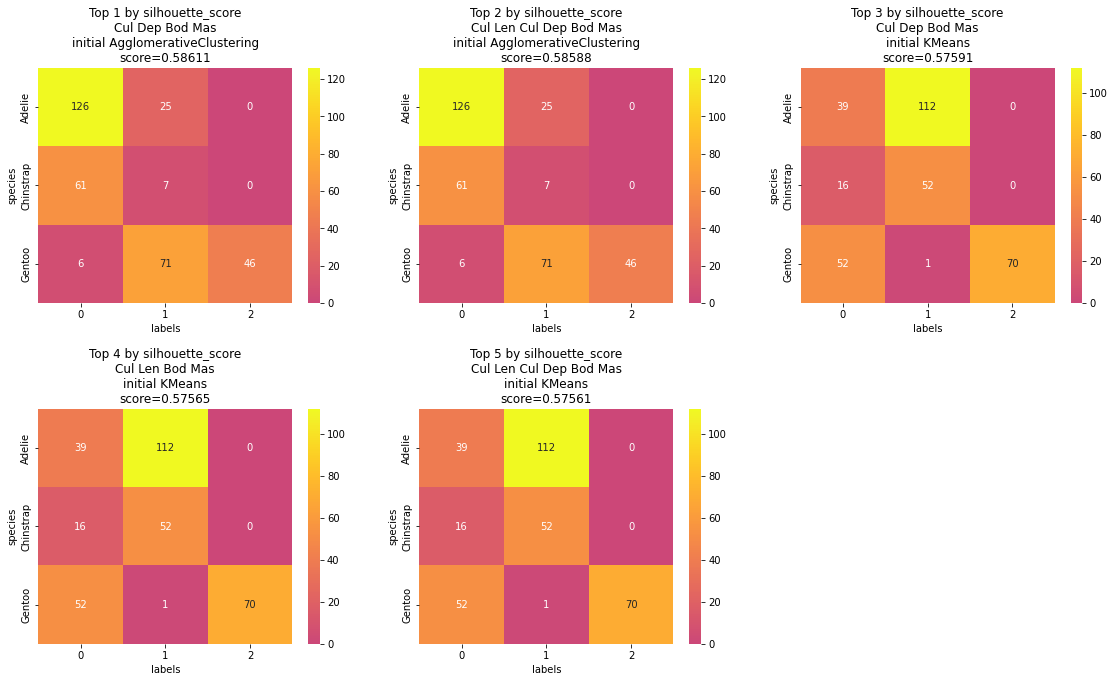

In [68]:
get_and_paint_top_labels(melted_silhouette_score_df, 'silhouette_score')

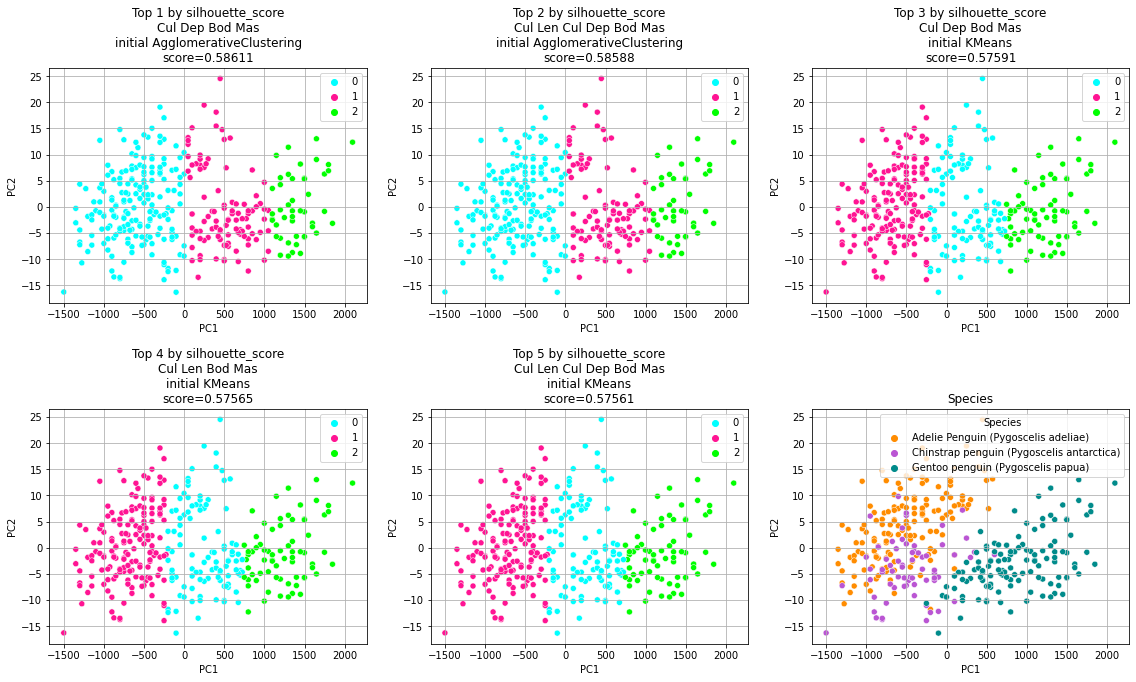

In [69]:
get_and_paint_top_points(melted_silhouette_score_df, 'silhouette_score')

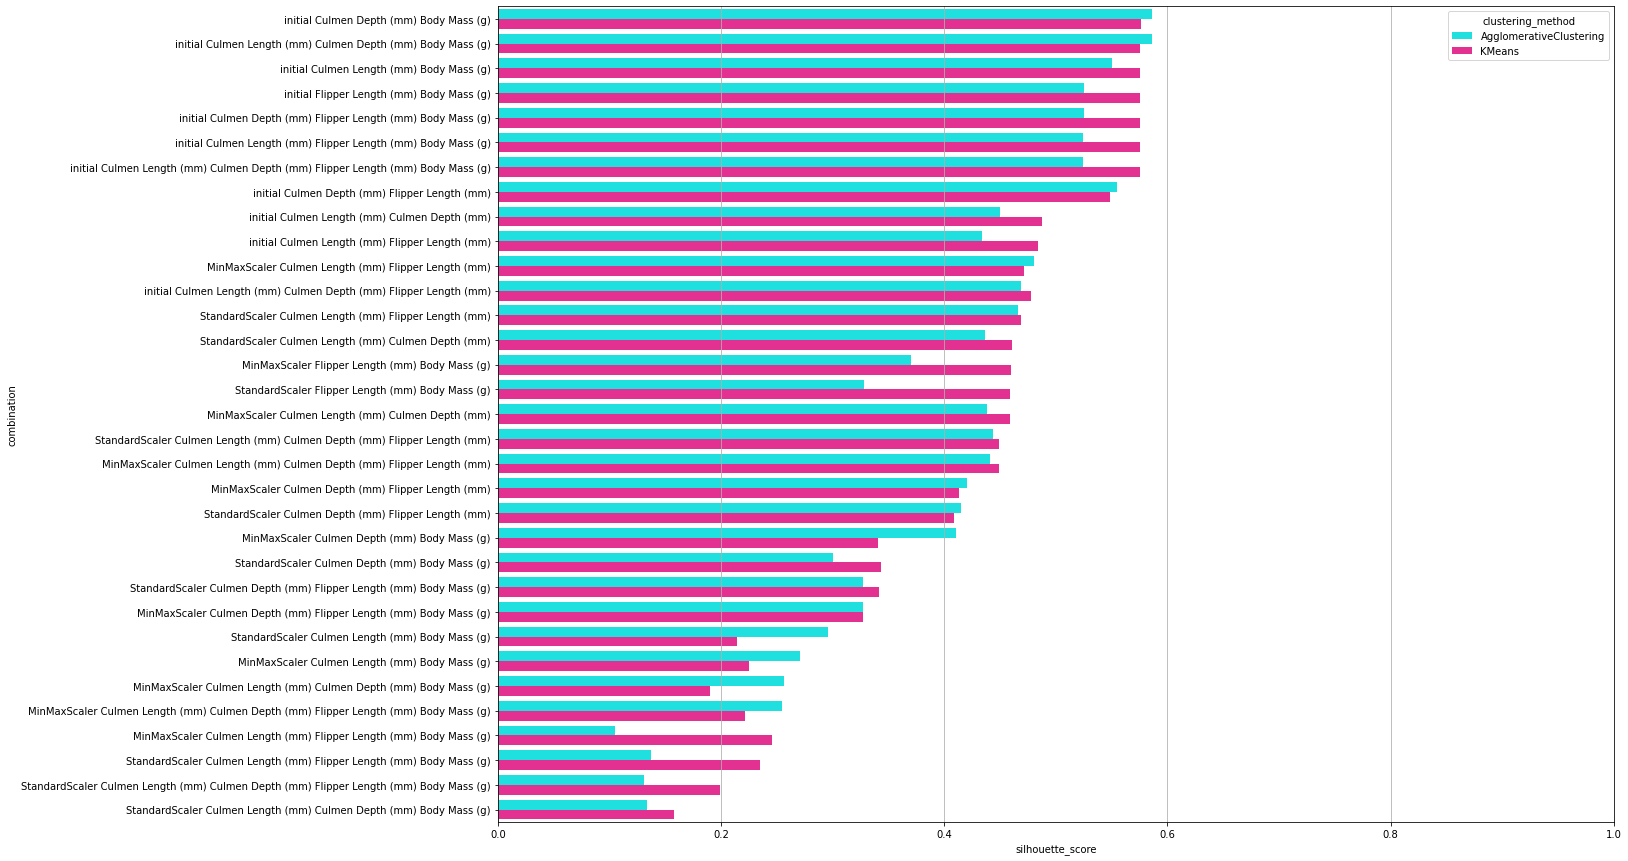

In [70]:
paint_metric_values(melted_silhouette_score_df, "silhouette_score")

##### Статистики для группировок

По методам

silhouette_score                                \
                                   count       min       max      mean   
clustering_method                                                        
AgglomerativeClustering               33  0.105138  0.586114  0.391481   
KMeans                                33  0.157727  0.575912  0.411074   

                                   
                           median  
clustering_method                  
AgglomerativeClustering  0.433667  
KMeans                   0.458576

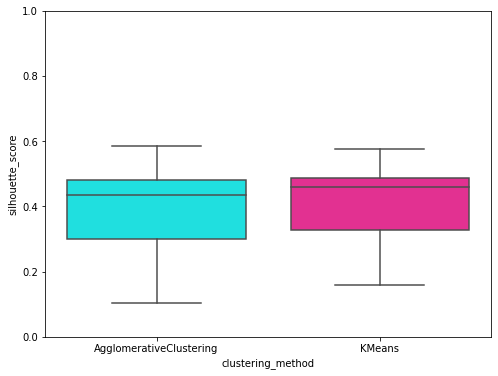

In [71]:
get_and_paint_statistics_for_grouping(melted_silhouette_score_df, "silhouette_score", ['clustering_method'])

В среднем лучше KMeans, медиана тоже больше. У Agglomerative больше диапазон, и, соответственно, чуть выше максимум.

По скейлерам

silhouette_score                                        
                          count       min       max      mean    median
scaler                                                                 
MinMaxScaler                 22  0.105138  0.480158  0.344428  0.355274
StandardScaler               22  0.130816  0.468446  0.325067  0.334787
initial                      22  0.433667  0.586114  0.534338  0.549181

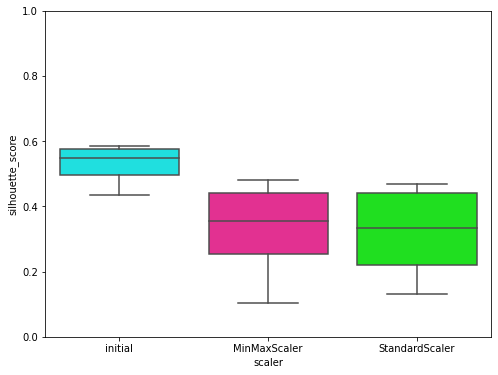

In [72]:
get_and_paint_statistics_for_grouping(melted_silhouette_score_df, "silhouette_score", ['scaler'])

Без скейлера лучше всего; MinMax чуть лучше, чем Standard.

Метод + скейлер

silhouette_score                      \
                                                  count       min       max   
scaler         clustering_method                                              
MinMaxScaler   AgglomerativeClustering               11  0.105138  0.480158   
               KMeans                                11  0.190120  0.471832   
StandardScaler AgglomerativeClustering               11  0.130816  0.466405   
               KMeans                                11  0.157727  0.468446   
initial        AgglomerativeClustering               11  0.433667  0.586114   
               KMeans                                11  0.477530  0.575912   

                                                            
                                            mean    median  
scaler         clustering_method                            
MinMaxScaler   AgglomerativeClustering  0.343176  0.370068  
               KMeans                   0.345681  0.340481  
StandardScaler AgglomerativeClustering  0.310415  0.327375  
               KMeans                   0.339720  0.343000  
initial        AgglomerativeClustering  0.520853  0.524841  
               KMeans                   0.547823  0.575182

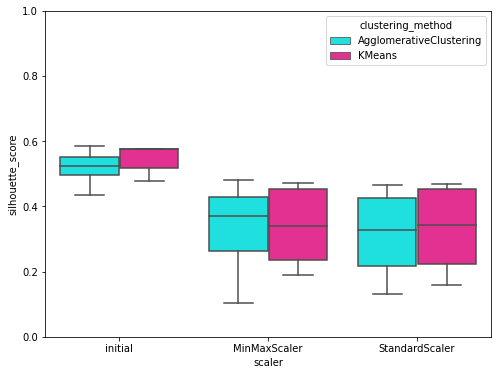

In [73]:
get_and_paint_statistics_for_grouping(melted_silhouette_score_df, "silhouette_score", ['scaler', 'clustering_method'])

У KMeans без скейлера максимум и медиана почти совпали, интересно. Эта же комбинация самая лучшая.

По комбинациям признаков

silhouette_score            \
                                                              count       min   
feature_combination                                                             
Culmen Depth (mm) Body Mass (g)                                   6  0.300284   
Culmen Depth (mm) Flipper Length (mm)                             6  0.409132   
Culmen Depth (mm) Flipper Length (mm) Body Mass...                6  0.327375   
Culmen Length (mm) Body Mass (g)                                  6  0.214183   
Culmen Length (mm) Culmen Depth (mm)                              6  0.436133   
Culmen Length (mm) Culmen Depth (mm) Body Mass (g)                6  0.133424   
Culmen Length (mm) Culmen Depth (mm) Flipper Le...                6  0.440859   
Culmen Length (mm) Culmen Depth (mm) Flipper Le...                6  0.130816   
Culmen Length (mm) Flipper Length (mm)                            6  0.433667   
Culmen Length (mm) Flipper Length (mm) Body Mas...                6  0.105138   
Flipper Length (mm) Body Mass (g)                                 6  0.328038   

                                                                        \
                                                         max      mean   
feature_combination                                                      
Culmen Depth (mm) Body Mass (g)                     0.586114  0.426112   
Culmen Depth (mm) Flipper Length (mm)               0.555256  0.460207   
Culmen Depth (mm) Flipper Length (mm) Body Mass...  0.575374  0.404014   
Culmen Length (mm) Body Mass (g)                    0.575652  0.355374   
Culmen Length (mm) Culmen Depth (mm)                0.487824  0.455207   
Culmen Length (mm) Culmen Depth (mm) Body Mass (g)  0.585879  0.316551   
Culmen Length (mm) Culmen Depth (mm) Flipper Le...  0.477530  0.454949   
Culmen Length (mm) Culmen Depth (mm) Flipper Le...  0.575155  0.317658   
Culmen Length (mm) Flipper Length (mm)              0.484195  0.467451   
Culmen Length (mm) Flipper Length (mm) Body Mas...  0.575182  0.303701   
Flipper Length (mm) Body Mass (g)                   0.575408  0.452835   

                                                              
                                                      median  
feature_combination                                           
Culmen Depth (mm) Body Mass (g)                     0.376940  
Culmen Depth (mm) Flipper Length (mm)               0.417646  
Culmen Depth (mm) Flipper Length (mm) Body Mass...  0.334559  
Culmen Length (mm) Body Mass (g)                    0.283476  
Culmen Length (mm) Culmen Depth (mm)                0.454381  
Culmen Length (mm) Culmen Depth (mm) Body Mass (g)  0.223333  
Culmen Length (mm) Culmen Depth (mm) Flipper Le...  0.449097  
Culmen Length (mm) Culmen Depth (mm) Flipper Le...  0.237992  
Culmen Length (mm) Flipper Length (mm)              0.470139  
Culmen Length (mm) Flipper Length (mm) Body Mas...  0.240017  
Flipper Length (mm) Body Mass (g)                   0.459311

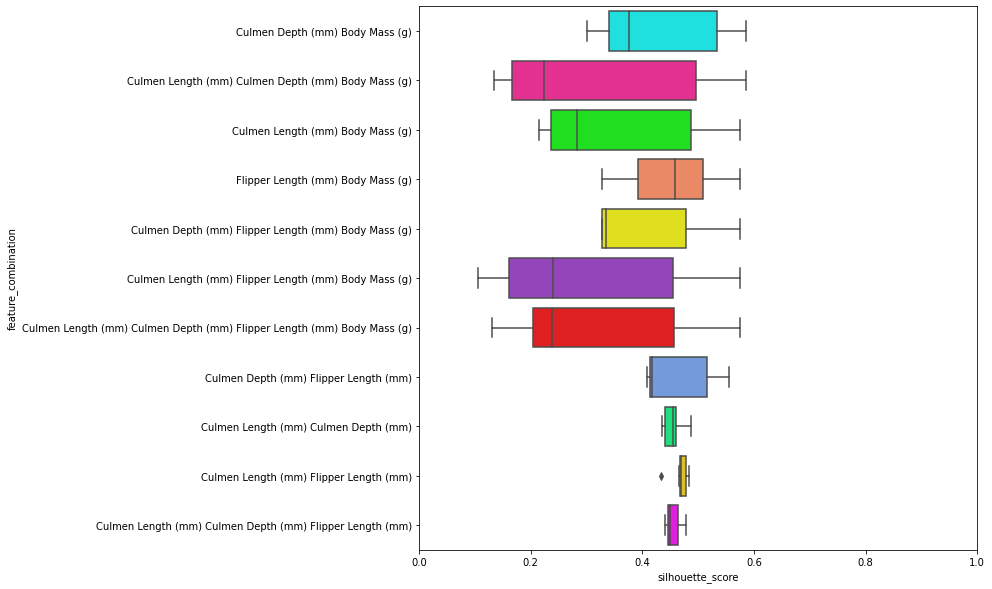

In [74]:
get_and_paint_statistics_for_grouping(melted_silhouette_score_df, "silhouette_score", ['feature_combination'])

Лучше всего Culmen Depth + Body Mass. Медиана в основном смещена вниз по отношению к среднему.

#### Анализ результатов для метрики в-скор

Значения в-скор значительно больше, чем силуэт => разбить пингвинов по критерию "похоже на разбиение по видам" удалось лучше, чем просто на отдельные группы.

##### Топ-5 и bar для всех

In [75]:
melted_v_measure_score_df[['feature_combination', 'scaler', 'clustering_method', 'v_measure_score']].head()

,feature_combination,scaler,clustering_method,v_measure_score
0,Culmen Length (mm) Culmen Depth (mm) Flipper L...,MinMaxScaler,AgglomerativeClustering,0.913783
1,Culmen Length (mm) Culmen Depth (mm) Flipper L...,StandardScaler,AgglomerativeClustering,0.912634
2,Culmen Length (mm) Culmen Depth (mm) Body Mass...,StandardScaler,AgglomerativeClustering,0.911382
3,Culmen Length (mm) Culmen Depth (mm) Flipper L...,StandardScaler,AgglomerativeClustering,0.900710
4,Culmen Length (mm) Culmen Depth (mm) Flipper L...,StandardScaler,KMeans,0.889110


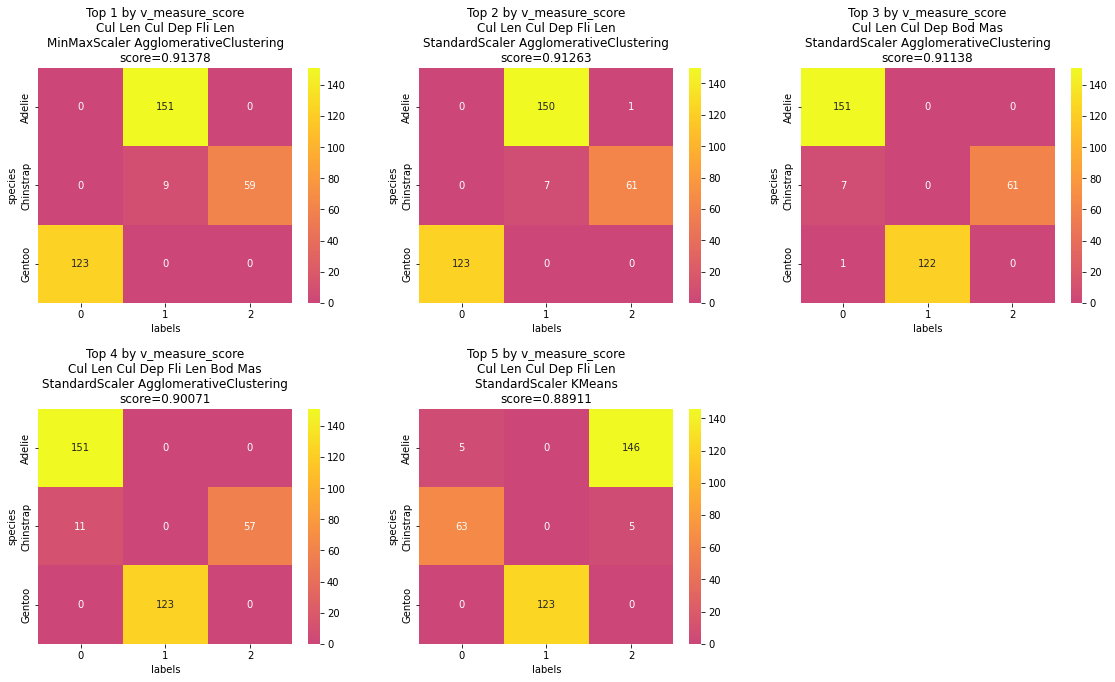

In [76]:
get_and_paint_top_labels(melted_v_measure_score_df, 'v_measure_score')

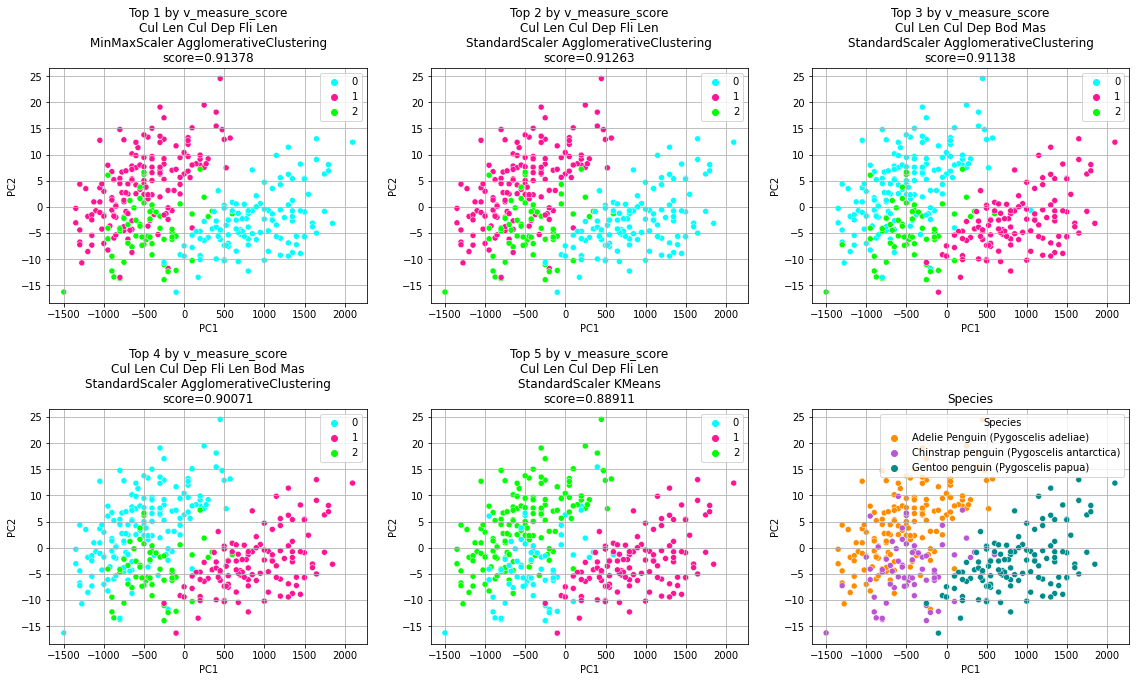

In [77]:
get_and_paint_top_points(melted_v_measure_score_df, 'v_measure_score')

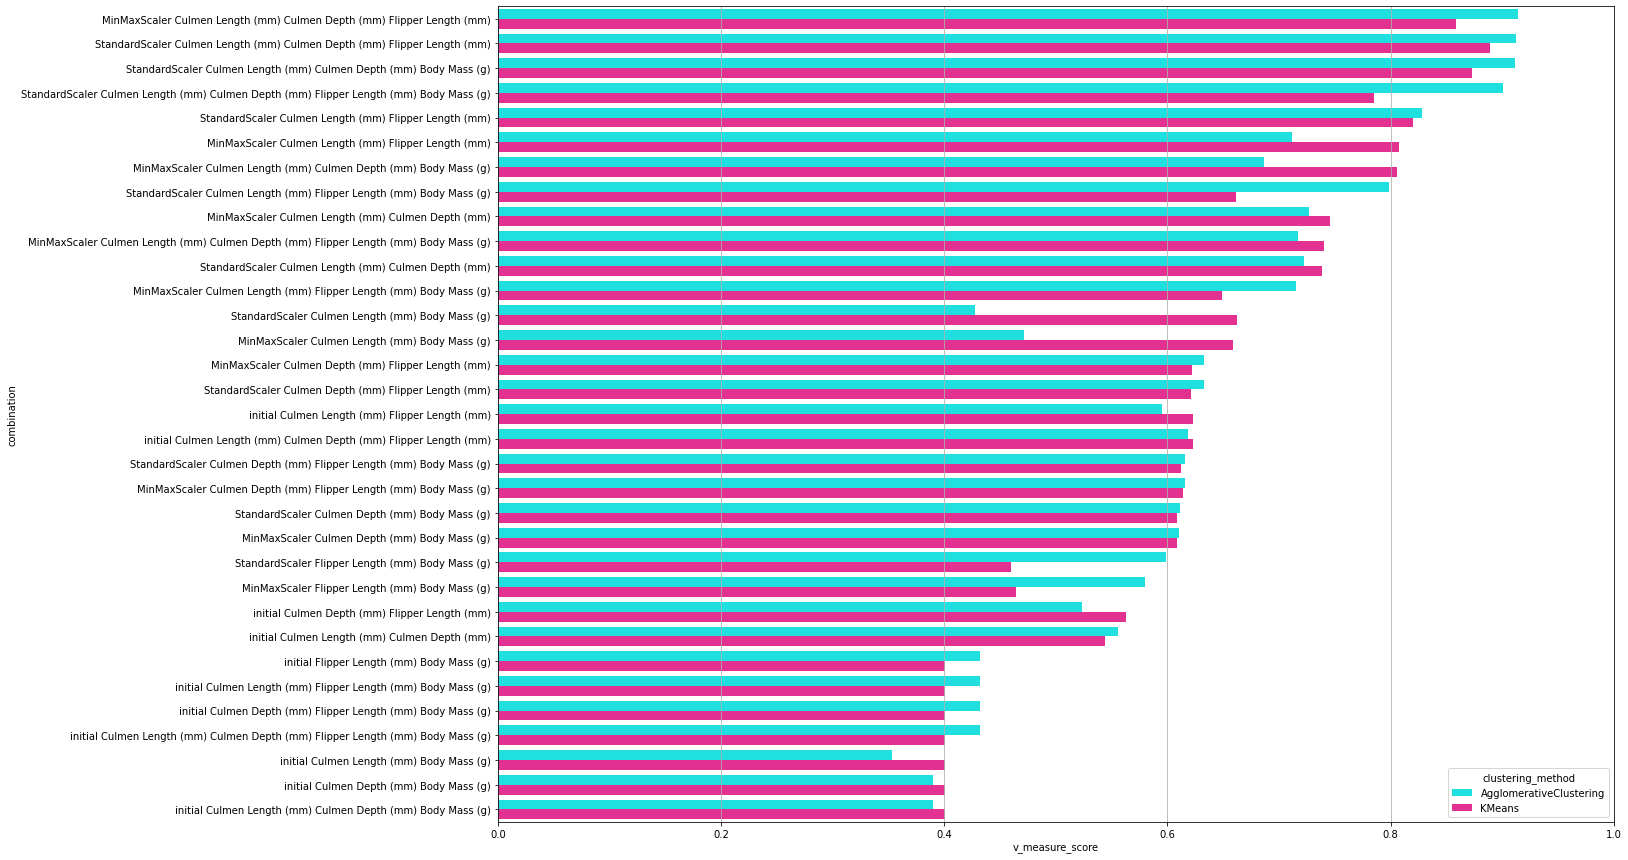

In [78]:
paint_metric_values(melted_v_measure_score_df, "v_measure_score")

##### Статистики по группировкам

Метод

v_measure_score                                \
                                  count       min       max      mean   
clustering_method                                                       
AgglomerativeClustering              33  0.352773  0.913783  0.621013   
KMeans                               33  0.400831  0.889110  0.620208   

                                   
                           median  
clustering_method                  
AgglomerativeClustering  0.615462  
KMeans                   0.622128

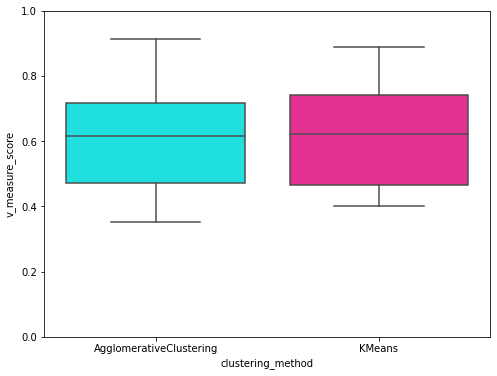

In [79]:
get_and_paint_statistics_for_grouping(melted_v_measure_score_df, "v_measure_score", ['clustering_method'])

Agglomerative лучше по максимуму и среднему, KMeans лучше по медиане. У Agglomerative больше диапазон.

Скейлер

v_measure_score                                        
                         count       min       max      mean    median
scaler                                                                
MinMaxScaler                22  0.464291  0.913783  0.679786  0.672434
StandardScaler              22  0.427449  0.912634  0.713291  0.692531
initial                     22  0.352773  0.622759  0.468755  0.432271

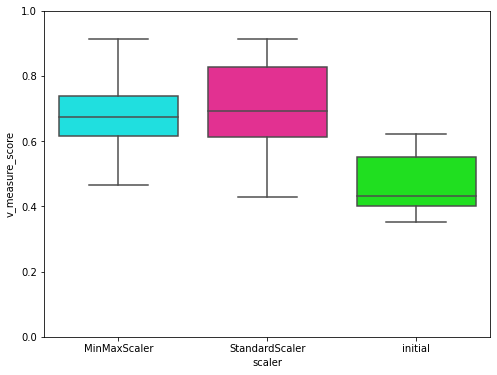

In [80]:
get_and_paint_statistics_for_grouping(melted_v_measure_score_df, "v_measure_score", ['scaler'])

StandardScaler лучше, разброс чуть больше. Без скалирования плохо.

Метод + скейлер

v_measure_score                      \
                                                 count       min       max   
scaler         clustering_method                                             
MinMaxScaler   AgglomerativeClustering              11  0.471600  0.913783   
               KMeans                               11  0.464291  0.858818   
StandardScaler AgglomerativeClustering              11  0.427449  0.912634   
               KMeans                               11  0.460000  0.889110   
initial        AgglomerativeClustering              11  0.352773  0.618554   
               KMeans                               11  0.400831  0.622759   

                                                            
                                            mean    median  
scaler         clustering_method                            
MinMaxScaler   AgglomerativeClustering  0.670977  0.686524  
               KMeans                   0.688596  0.658345  
StandardScaler AgglomerativeClustering  0.723540  0.722392  
               KMeans                   0.703041  0.662670  
initial        AgglomerativeClustering  0.468523  0.432271  
               KMeans                   0.468986  0.400831

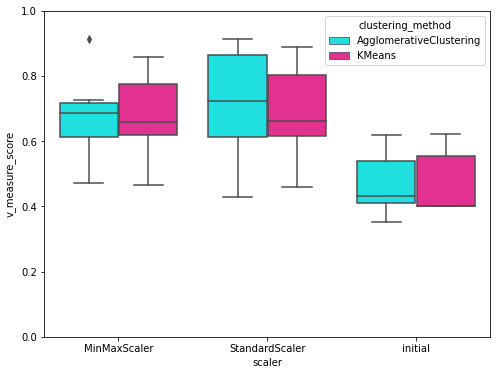

In [81]:
get_and_paint_statistics_for_grouping(melted_v_measure_score_df, "v_measure_score", ['scaler', 'clustering_method'])

В целом лучше всего Agglomerative + Standard, но в одном случае хороший результат у Agglomerative + MinMax. Без скалирования значительно хуже обоими методами.

Комбинация признаков

v_measure_score            \
                                                             count       min   
feature_combination                                                            
Culmen Depth (mm) Body Mass (g)                                  6  0.389924   
Culmen Depth (mm) Flipper Length (mm)                            6  0.523058   
Culmen Depth (mm) Flipper Length (mm) Body Mass...               6  0.400831   
Culmen Length (mm) Body Mass (g)                                 6  0.352773   
Culmen Length (mm) Culmen Depth (mm)                             6  0.544484   
Culmen Length (mm) Culmen Depth (mm) Body Mass (g)               6  0.389924   
Culmen Length (mm) Culmen Depth (mm) Flipper Le...               6  0.618554   
Culmen Length (mm) Culmen Depth (mm) Flipper Le...               6  0.400831   
Culmen Length (mm) Flipper Length (mm)                           6  0.595058   
Culmen Length (mm) Flipper Length (mm) Body Mas...               6  0.400831   
Flipper Length (mm) Body Mass (g)                                6  0.400831   

                                                                        \
                                                         max      mean   
feature_combination                                                      
Culmen Depth (mm) Body Mass (g)                     0.611126  0.538246   
Culmen Depth (mm) Flipper Length (mm)               0.632806  0.599148   
Culmen Depth (mm) Flipper Length (mm) Body Mass...  0.615462  0.548378   
Culmen Length (mm) Body Mass (g)                    0.662670  0.495611   
Culmen Length (mm) Culmen Depth (mm)                0.745264  0.672285   
Culmen Length (mm) Culmen Depth (mm) Body Mass (g)  0.911382  0.677916   
Culmen Length (mm) Culmen Depth (mm) Flipper Le...  0.913783  0.802610   
Culmen Length (mm) Culmen Depth (mm) Flipper Le...  0.900710  0.662837   
Culmen Length (mm) Flipper Length (mm)              0.827719  0.730814   
Culmen Length (mm) Flipper Length (mm) Body Mas...  0.798868  0.609593   
Flipper Length (mm) Body Mass (g)                   0.598410  0.489278   

                                                              
                                                      median  
feature_combination                                           
Culmen Depth (mm) Body Mass (g)                     0.608772  
Culmen Depth (mm) Flipper Length (mm)               0.621605  
Culmen Depth (mm) Flipper Length (mm) Body Mass...  0.613119  
Culmen Length (mm) Body Mass (g)                    0.449524  
Culmen Length (mm) Culmen Depth (mm)                0.724834  
Culmen Length (mm) Culmen Depth (mm) Body Mass (g)  0.746075  
Culmen Length (mm) Culmen Depth (mm) Flipper Le...  0.873964  
Culmen Length (mm) Culmen Depth (mm) Flipper Le...  0.728853  
Culmen Length (mm) Flipper Length (mm)              0.759535  
Culmen Length (mm) Flipper Length (mm) Body Mas...  0.655286  
Flipper Length (mm) Body Mass (g)                   0.462145

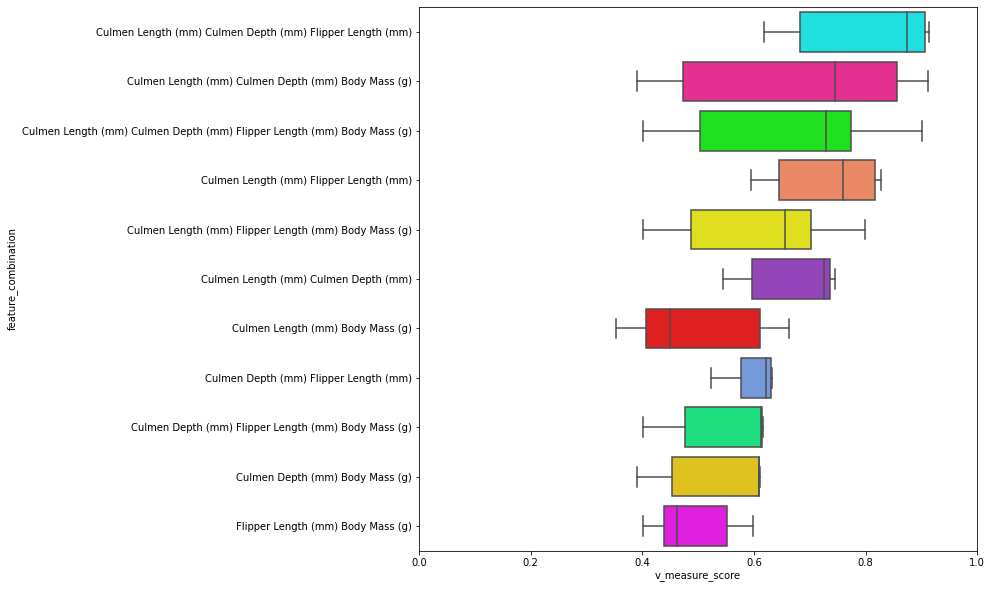

In [82]:
get_and_paint_statistics_for_grouping(melted_v_measure_score_df, "v_measure_score", ['feature_combination'])

Самые лучшие Culmen Length + Culmen Depth + Flipper Length и Culmen Length + Culmen Depth + Body Mass (что логично, так как Flipper Length и Body Mass практически линейно зависимы). У всех признаков в основном медиана смещена вверх.